# Выбор изображений по текстовому описанию

## Описание проекта

Мы работаетем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Наш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Нам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

### Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

    This image is unavailable in your country in compliance with local laws.
    
Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

### Описание данных

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберем либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

Данные проект выполняется в Google Colab. Данные были предварительно загружены на Google диск. Прописываем путь к данным.

In [175]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
path='/content/drive/MyDrive/to_upload'



Установим дополнительные библиотеки Keras-NLP и Sentence-Transformers.

In [177]:
!pip install -q --upgrade keras-nlp tensorflow
!pip install -q sentence-transformers

Осуществим импорт библиотек.

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords') # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet') # проводит лемматизацию
nltk.download('omw-1.4')

from PIL import Image

from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Для обеспечения воспроизводимости данных зададим глобальные переменные и установим рандомайзеры. В переменной BLOCK создадим пречень слов, которые могут быть признаком наличия запрещенного контента.

In [179]:
PATH = path
SEED = 1234

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [180]:
BLOCK = ['kid','child','toddler','teenager',
        'teen','tyke','tike','offspring',
        'youngling','sprout','bambino',
        'kiddo','progeny','teenybopper',
        'junior','growing-up','boy','lad',
        'youngster','girl','adolescent',
        'lass','lassie','tot','sprog',
        'juvenile','pubescent','pubertal',
        'young','youthful','infant','baby',
        'bebe','newborn']

Прочитаем данные из файлов.

In [181]:
df_train = pd.read_csv(path +'/train_dataset.csv')
df_images = pd.read_csv(path +'/test_images.csv')
df_crowd = pd.read_csv(path+'/CrowdAnnotations.tsv', sep='\t', header =None)
df_crowd.columns=['image', 'query_id','share_pos', 'count_pos', 'count_neg']
df_expert = pd.read_csv(path+'/ExpertAnnotations.tsv', sep='\t',
                        names=['image', 'query_id', 'first',
                        'second', 'third'])
df_queries = pd.read_csv(path+'/test_queries.csv', index_col=[0], sep='|')






Посмотрим на данные.

In [182]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [183]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [184]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [185]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [186]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


Проверяем количество изображений  в обучающем и тестовом наборах, а также наличие совпадающих изображений.

In [187]:
print('Уникальных изображений в обучающем датасете:', len(set(df_train['image'])))
print('Уникальных изображений в тестовом датасете:', len(set(df_queries['image'])))
print('Уникальных изображений которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальных изображений в обучающем датасете: 1000
Уникальных изображений в тестовом датасете: 100
Уникальных изображений которые есть в обоих наборах: 0


Проверяем количество описаний в двух датасетах, а
также наличие совпадающих описаний в обучающем и тестовом наборах.

In [188]:
print('Уникальных текстовых описаний в обучающем датасете:', (df_train['query_text'].nunique()))
print('Уникальных текстовых описаний в тестовом датасете:', (df_queries['query_text'].nunique()))
print('Уникальных текстовых описаний которые есть в обоих наборах:', len(set(df_train['query_text']) & set(df_queries['query_text'])))

Уникальных текстовых описаний в обучающем датасете: 977
Уникальных текстовых описаний в тестовом датасете: 500
Уникальных текстовых описаний которые есть в обоих наборах: 0


Посмотрим на количество оценок в экспертном и краудсорсинговом наборах.

In [189]:
print('Количество уникальных сочетаний фото-текст оцененных экспертами:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний фото-текст оцененных людьми:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст оцененных людьми: 47830


Проверим, все ли текстовые описания в тестовом наборе совпадают с картинками. В столбце `query_id` зашифрована информация о номере картинки к которой дано описание в столбце `query_text`.

In [190]:
df_queries[df_queries['query_id'].str[:-2] != df_queries['image']].shape[0]

0

Познакомимся с изображениями, входящими в датасеты.

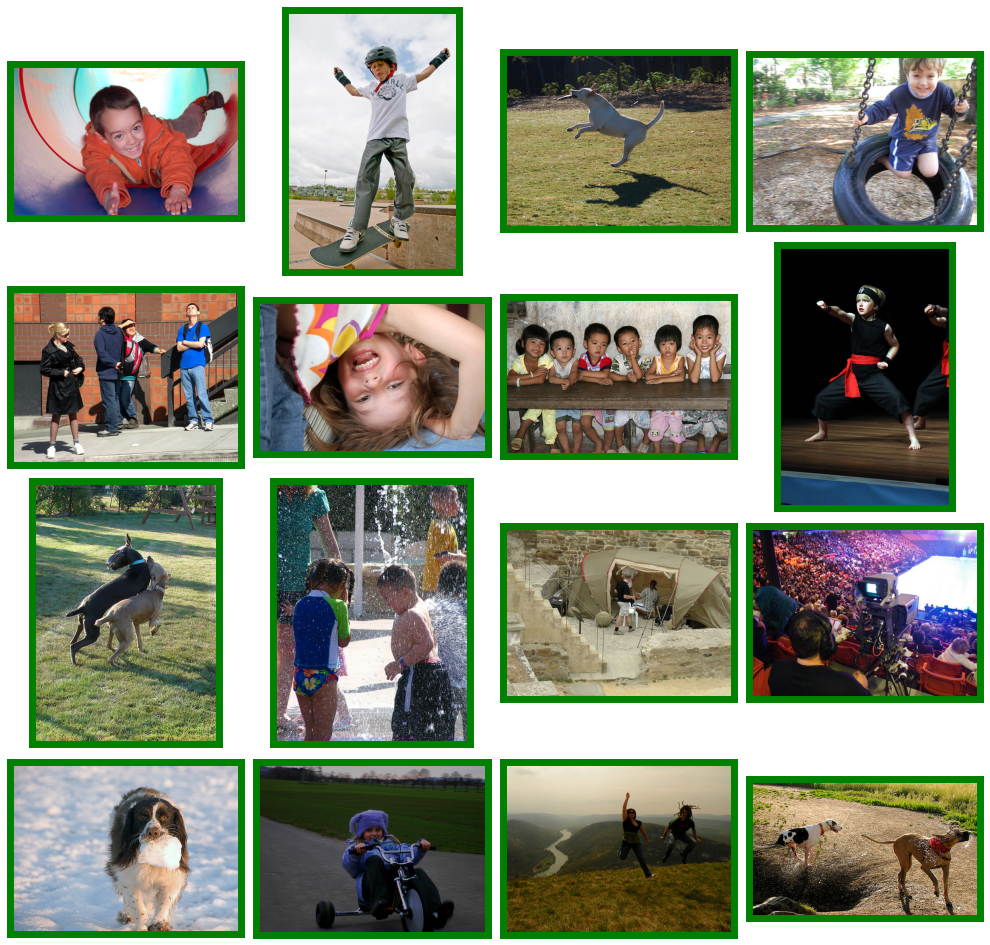

In [191]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы

Мы загрузили и ознакомились с данными.

Обучающий датасет содержит 1000 изображений и 977 текстовых описаний к ним. Текстовый датасет содержит 100 уникальных изображений и 500 текстовых описаний..

Для обучающего датасета имеются   как экспертные оценки соответствия 5822 шт. так и оценки выполненные на краудфайдинговой платформе обычными людьми - 47830 шт, они частично совпадают.

Пересечений между наборами данных для двух датасетов  не обнаружено.


Перейдём к аггрегации оценок для тестового датасета.

## Агрегирование оценок экспертов и пользователей.

Напишем функцию для агрегации оценок экспертов и применим к набору данных.

Если все оценки разные - будем усреднять оценку и приводить к диапазону [0,1], если есть несколько одинаковых оценок - проголосуем большинством.

In [192]:
def expert_aggregate(row) -> object:

    '''агрегируем экспертную оценку усреднением ответов и сведением к диапазону [0,1]'''

    if row['first'] != row['second'] != row['third']: #если оценки разные усредняем
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3

    else: #если есть одинаковые оценки - аггрегируем голосованием
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3

    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)
df_expert.expert_score.describe()


count    5822.000000
mean        0.208157
std         0.285431
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: expert_score, dtype: float64

In [193]:
df_expert.expert_score.value_counts()

0.000000    3327
0.333333    1664
0.666667     518
1.000000     311
0.444444       2
Name: expert_score, dtype: int64

Поскольку только 2329 пар картинка-текст имеют оценки и людей и экспертов мы объединим оба блока с оценками с флагом `left`. Таким образом у чать пар имеющих оценки публики будут утрачены. Это делается поскольку инуитивно мы имеем большее доверие к оценке экспертов.

In [194]:
df_scores = pd.merge(df_expert, df_crowd, how='left', on=['image', 'query_id'])

def score_aggregate(row) -> object:

    '''аггрегируем оценки людей и экспертов'''

    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['share_pos'] * 0.3

    return row

df_scores = df_scores.apply(score_aggregate, axis=1)

Проверим результат.

In [195]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   first         5822 non-null   int64  
 3   second        5822 non-null   int64  
 4   third         5822 non-null   int64  
 5   expert_score  5822 non-null   float64
 6   share_pos     2329 non-null   float64
 7   count_pos     2329 non-null   float64
 8   count_neg     2329 non-null   float64
 9   score         5822 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 500.3+ KB


In [196]:
df_scores['score'].describe()

count    5822.000000
mean        0.183894
std         0.264845
min         0.000000
25%         0.000000
50%         0.000000
75%         0.333333
max         1.000000
Name: score, dtype: float64

In [197]:
df_scores.score.value_counts().sort_index()


0.000000    3322
0.075000       1
0.100000       4
0.233333     843
0.293333       2
0.308333       2
0.333333      87
0.333333     707
0.383333       2
0.433333      19
0.444444       2
0.466667     190
0.533333       2
0.541667       3
0.566667     148
0.586667       2
0.616667       2
0.666667      55
0.666667      77
0.691667       2
0.700000       1
0.706667       2
0.766667      37
0.800000      18
0.900000      62
1.000000     230
Name: score, dtype: int64

Обратим внимание, что количество описаний, полностью соответствующих изображению очень невелико - всего 230, скорее всего к ним можно добавить 62 описания набравших оценку 0.9, но все равно число корректных описаний остается недостаточным. Очевидно, что большинство изображений из тренировочного датасета не имеют корректных текстовых описаний. Представляется, что низкое качество разметки может оказаться препятствием для построения приемлемой модели. В принципе, данную проблему можно было бы решить доразметив датасет вручную, то есть добавить описание каждого изображения. К сожалению не имеется достаточно времени для реализации разметки вручную.

Добавим целевую функцию в обучающий датафрейм.

In [198]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='left', on=['image', 'query_id'])

In [199]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   score       5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


Проверяем данные на наличие дубликатов

In [200]:
df_train.duplicated().sum()

0

In [201]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   score       5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 227.4+ KB


### Выводы

Выбрали метод объединения оценок экспертов и пользователей,  агрегировали оценки. Объединили оценки с обучающим набором данных, проверили данных на наличие пропусков и дубликтов. Отметим низкое качество данных, далеко не все изображения имеют корректное текстовое описание. Возможно это окажется препятствием при обучении модели.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Для избавления от нелегального контента мы воспользуемся текстовыми описаниями файлов.

Объявим список слов для поиска нелегального контента.

Очистим, токенизируем и лемматизируем текст, чтобы было легче искать запросы связанные с детьми. Отметим в обучающем наборе фото подлежащие блокировке.

In [202]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:

    '''очищаем текст и превращаем в список лемм'''

    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова

    return text

def cleaning(row) -> object:

    '''отмечаем тексты для блокирования'''

    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [203]:
%time df_train = df_train.apply(cleaning, axis=1)

CPU times: user 7.03 s, sys: 46.3 ms, total: 7.08 s
Wall time: 13.7 s


Просмотрим какие тексты оказались заблокированны.

In [204]:
print(df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique())

['A little girl is sliding down a tunnel smiling .'
 'Two children playing with a ball on the grass .'
 'A boys jumps in the water while another boy looks on .'
 'A boy runs to a baseball base .'
 'A kid in a blue top leaps into a raked pile of leaves in front of trees .'
 'a boy plays with a noodle by the pool .'
 'Three little girls make silly faces on a wooden swing in an over saturated photo .'
 'a boy jumps into the blue pool water .'
 'A little boy in a striped shirt is standing behind a tree .'
 'Two girls pass two boys by a tree in a neon lit street .']


Также посмотрим на случайные картинки которые попали под правило блокировки. Для поиска картинок воспользуемся тем что поле `query_id` таблицы `df_train` содержит закодированное имя картинки соответствующей этому описанию.

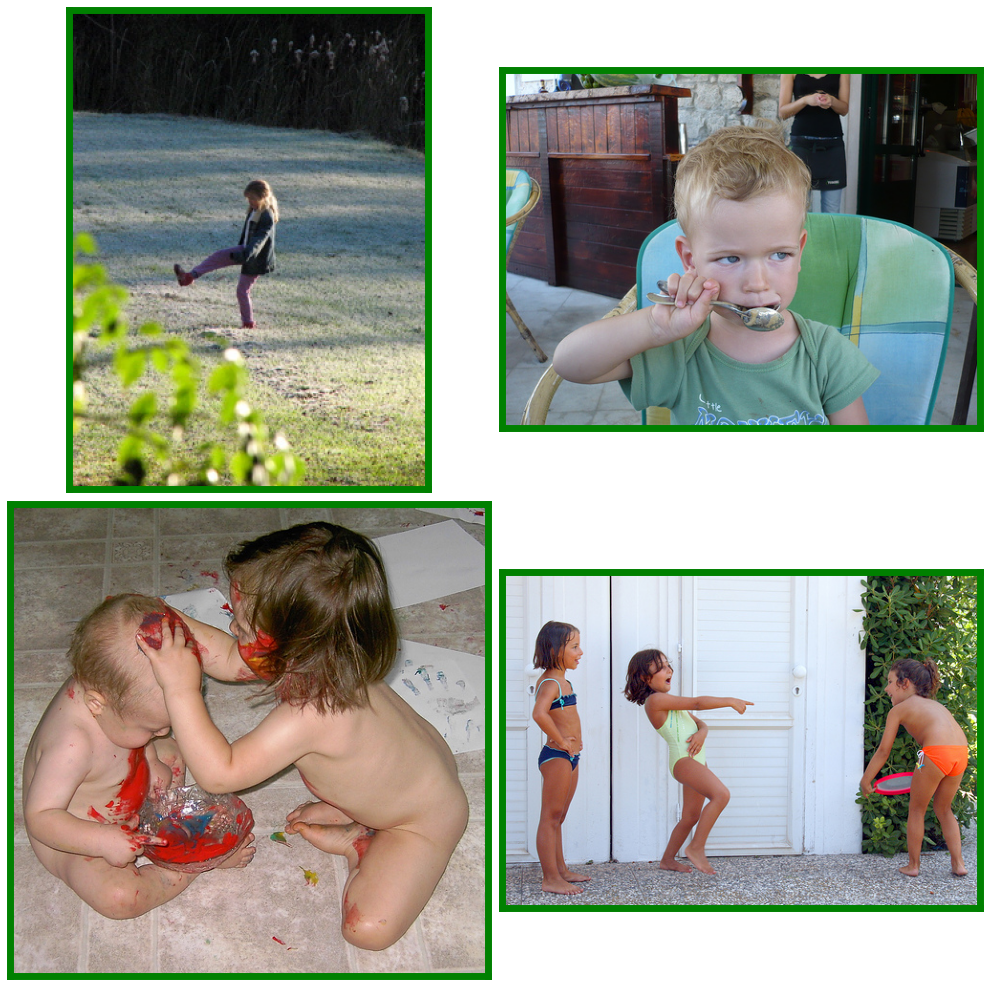

In [205]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(4):
    fig.add_subplot(2, 2, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Похоже что мы верно отметили фотографии. Удалим строки с фото с детьми из набора данных.

In [206]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

Проверим полученные датасеты.

In [207]:
display(df_train.head(), df_queries.head())
df_train.info()
print('-' * 100)
df_queries.info()

,image,query_id,query_text,score
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.333333
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.233333
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.333333
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.000000


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4188 entries, 0 to 4187
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4188 non-null   object 
 1   query_id    4188 non-null   object 
 2   query_text  4188 non-null   object 
 3   score       4188 non-null   float64
dtypes: float64(1), object(3)
memory usage: 131.0+ KB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [208]:
df_train.score.value_counts().sort_index()

0.000000    2307
0.075000       1
0.100000       3
0.233333     615
0.293333       1
0.308333       2
0.333333      68
0.333333     484
0.383333       2
0.433333      14
0.444444       2
0.466667     158
0.533333       1
0.541667       3
0.566667     123
0.586667       1
0.616667       2
0.666667      42
0.666667      69
0.691667       1
0.706667       1
0.766667      32
0.800000      16
0.900000      51
1.000000     189
Name: score, dtype: int64

### Выводы

Мы проверили данные и исключили из обучения все описания содержащие упоминания несовершенолетних. Таким образом создан датафрейм которые будет использоваться в для векторизации текстовю Отметим, что в результате удаления нелегитимной информации количество корректных описаний изображений сократилось еще больше. Недостаточное количестов корректных текстовых описаний представляется существенным препятствием для обучения моделей.

Перейдём к векторизации изображений.

## Векторизация изображений

Для векторизации изображений воспользуемся в качестве бэкбона архитектурой ResNet-50 предобученной на датасете ImageNet.

Напишем функции загрузчиков изображений.

In [209]:
def load_train(path=PATH) -> ImageDataGenerator:

    '''загрузчик данных для обучения'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)

    return train_gen_flow

Проверим выдачу полученного генератора.

In [210]:
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(8):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Как видим в наборе оказались изображения несовершеннолетних, что не удивительно, принимая во внимание, что технически, мы отфильтровали записи, а не изображения. Как мы убедились ранее большинство пар обписаний и изображений не совпадаю, пожтому исключить детские изображения из выдачи, фильтруя текст на этапе обучения невозможно.

Объявляем модель.

In [211]:
def create_model(input_shape=(256, 256, 3)):

    '''задаём архитектуру сети'''

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

Получаем эмбеддинги изображений.

In [212]:
def vectorize_pictures(model, train_data):

    '''превращаем данные в вектор'''

    predictions = model.predict(train_data)

    return predictions

In [213]:
%%time

pict_embeds = vectorize_pictures(create_model(), load_train())

Found 4188 validated image filenames.
262/262 [==============================] - 41s 151ms/step
CPU times: user 37.7 s, sys: 2.68 s, total: 40.3 s
Wall time: 44.4 s


In [133]:
pict_embeds.shape

(4188, 2048)

### Выводы

С помощью предобученной модели ResNet50 получены векторы изображений из обучающего датасета. Размерность матрицы 4188*2048.

## Векторизация текстов

Для векторизации тектов используется трансформер BERT из библиоетки Keras-NLP.

Загрузим трансформер BERT base cased EN без классифицирующей головы.

In [35]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/bert/keras/bert_base_en/2/download/config.json...
100%|██████████| 510/510 [00:00<00:00, 330kB/s]
INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/bert/keras/bert_base_en/2/download/model.weights.h5...
100%|██████████| 414M/414M [00:10<00:00, 42.8MB/s]
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Загрузим препроцессор

In [215]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

Функцию для получения эмбеддингов.

In [216]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:

    '''преобразуем тексты в словарь токенов, масок и паддингов'''

    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):

            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]

            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}

            batch_embeddings = model.predict(batch, verbose=verbose)

            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

Преобразуем наши тексты для подачи в функцию.

In [217]:
text = list(df_train['query_text'])

Запустим получение эмбеддингов.

In [218]:
%%time

text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/131 [00:00<?, ?it/s]

CPU times: user 3min 11s, sys: 6.74 s, total: 3min 18s
Wall time: 3min 58s


In [220]:
text_embeds.shape

(4188, 768)

### Выводы

Текст векторизирован с помощью BERT base cased EN размер матрицы эмбедингов 4188*768.

## 5. Объединение векторов

Объединим векторы изображений и векторы текстов с целевой переменной.

In [221]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(4188, 2816)

In [222]:
y = np.array(df_train['score'])
y.shape

(4188,)

Чтобы на каждом эксперименте с моделями не пересчитывать векторы, сохраним данные для последующей быстрой загрузки.

In [223]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

In [224]:
'''with open('X.pickle', 'rb') as f:
    X = pickle.load(f)
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)
print(X.shape)
print(y.shape)'''

"with open('X.pickle', 'rb') as f:\n    X = pickle.load(f)\nwith open('y.pickle', 'rb') as f:\n    y = pickle.load(f)\nprint(X.shape)\nprint(y.shape)"

### Выводы

Признаки и целевые переменные готовы, можно переходить к  обучению модели.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом `GroupShuffleSplit` из библиотеки `sklearn.model_selection`.

Сначала получим обучающую и тестовые выборки.

In [232]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [233]:
X_train, X_test = X[train_indices], X[test_indices]

In [234]:
y_train, y_test = y[train_indices], y[test_indices]

In [243]:
X_train.shape

(3305, 2816)

In [244]:
y_train.shape

(3305,)

In [245]:
X_test.shape

(883, 2816)

In [246]:
y_test.shape

(883,)

Отмасштабируем наши данные.

In [254]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### LinearRegression

В качестве baseline'а попробуем модель линейной регрессии.

#### Выбор метрики
Перед нами стоит задача предсказания соответствия текста и картинки, наша модель должна выводить несколько фотографий, соответствующих описанию.

Наиболее популярными метриками для непрерывных переменных являются MSE (среднеквадратичная ошибка (Mean Squared Error)), RMSE (корень из среднеквадратичной ошибки (Root Mean Squared Error)) и MAE (средняя абсолютная ошибка (Mean Absolute Error)).

При выборе метрики качества будем исходить из следующего.

Достоинство RMSE в простоте интерпретации, поскольку она измеряется в тех же единицах, что и целевая переменная. Недостатком данной метрики является тенденция к занижению качества модели, чувствительность к выбросам. Но занижать - не завышать, а MSE тоже чувствительна к выбросам, однако интерпретировать ее сложнее из-за квадратичной зависимости.

MAE оказывается менее чувствительна к выбросам в данных, кроме того эта метрика менее затратна с точки зрения выислительных ресурсов.

В указанной связи метрикой качества линейной регрессии изберем MAE, на снижение которой будем ориентироваться.

In [290]:
%%time
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
score = cross_val_score(
    model, X_train, y_train, groups=df_train['image'].loc[train_indices],
    scoring='neg_mean_absolute_error',
    cv=GroupShuffleSplit(random_state=SEED)
).mean()
abs(score).round(decimals=3)

CPU times: user 36.7 s, sys: 7.76 s, total: 44.5 s
Wall time: 32.2 s


6.753

Проверим на тесте.

In [292]:
pred = model.predict(X_test)
mean_absolute_error(y_test, pred).round(decimals=3)

2.092

### LinearSVR

Попробуем модель на основе метода опорных векторов.

Зададим параметры сетки для перебора в GridSearch.

In [293]:
model = LinearSVR(random_state=SEED)

param_grid = {
    'loss':['squared_epsilon_insensitive'],
    'C':[1]
}

gs_svr = GridSearchCV(
    model,
    param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=GroupShuffleSplit(n_splits=3, random_state=SEED),
    verbose=1
)

Проведём подбор гиперпараметров.

In [294]:
%time gs_svr.fit(X_train, y_train, groups=df_train['image'].loc[train_indices])
None

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 25 s, sys: 403 ms, total: 25.4 s
Wall time: 1min 19s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [295]:
gs_svr.best_score_

-0.31253908936870706

Посмотрим на результат.

In [296]:
pd.DataFrame(gs_svr.cv_results_)[['param_C', 'param_loss', 'mean_test_score', 'rank_test_score']].round(decimals=3)

,param_C,param_loss,mean_test_score,rank_test_score
0,1,squared_epsilon_insensitive,-0.313,1


Проверим полученную модель на тесте.

In [297]:
pred = gs_svr.predict(X_test)
mean_absolute_error(y_test, pred).round(decimals=3)

0.318

Результат лучше чем в случае с линейной регрессией, но, ,по-прежнему, крайне далек от приемлемых значений.

### NeuralNetwork

Создадим четырехслойную полносвязную сеть с Батчнормализацией на каждом слое, дропаутами 0.2 на внутреннем слое, функцией активации 'relu' на всех слоях кроме последнего, на последнем слое используем линейную активацию. Размер батча установим в 32, а количество эпох - 70.

In [283]:
X_train.shape

(3305, 2816)

In [284]:
NN = Sequential()
NN.add(Dense(512, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dropout(0.2))
#NN.add(Dense(256, activation='relu'))
#NN.add(BatchNormalization())
#NN.add(Dropout(0.2))
NN.add(Dense(128, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dropout(0.2))
NN.add(Dense(64, activation='relu'))
NN.add(Flatten())
NN.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=1e-5)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics='mean_absolute_error')
            #metrics=[tf.keras.metrics.RootMeanSquaredError()])

NN.build()

NN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               1442304   
                                                                 
 batch_normalization_20 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 128)               65664     
                                                                 
 batch_normalization_21 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)             

In [287]:
model_nn = NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=70,
    verbose=2, shuffle=True
    )

Epoch 1/70
104/104 - 2s - loss: 0.2135 - mean_absolute_error: 0.3634 - val_loss: 0.1320 - val_mean_absolute_error: 0.2913 - 2s/epoch - 15ms/step
Epoch 2/70
104/104 - 1s - loss: 0.2118 - mean_absolute_error: 0.3594 - val_loss: 0.1295 - val_mean_absolute_error: 0.2901 - 1s/epoch - 13ms/step
Epoch 3/70
104/104 - 1s - loss: 0.1913 - mean_absolute_error: 0.3431 - val_loss: 0.1280 - val_mean_absolute_error: 0.2890 - 1s/epoch - 12ms/step
Epoch 4/70
104/104 - 1s - loss: 0.1973 - mean_absolute_error: 0.3467 - val_loss: 0.1311 - val_mean_absolute_error: 0.2945 - 903ms/epoch - 9ms/step
Epoch 5/70
104/104 - 1s - loss: 0.1947 - mean_absolute_error: 0.3466 - val_loss: 0.1292 - val_mean_absolute_error: 0.2904 - 614ms/epoch - 6ms/step
Epoch 6/70
104/104 - 1s - loss: 0.1941 - mean_absolute_error: 0.3473 - val_loss: 0.1271 - val_mean_absolute_error: 0.2867 - 543ms/epoch - 5ms/step
Epoch 7/70
104/104 - 1s - loss: 0.1915 - mean_absolute_error: 0.3432 - val_loss: 0.1261 - val_mean_absolute_error: 0.2872 - 

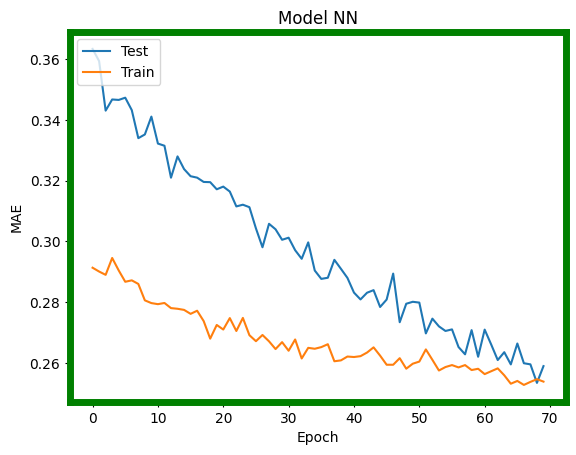

In [288]:
plt.plot(model_nn.history['mean_absolute_error'])
plt.plot(model_nn.history['val_mean_absolute_error'])
plt.title('Model NN')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

### Выводы

Линейная регрессия показала очень плохой результат, метод опорных векторов показал MAE намного лучше, однако уступил полносвязной нейронной сети, показавшей MAE - 0.2538 на валидационной выборке. Даже у нейросети средняя абсолютная ошибка получилась очень большой.


## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [58]:
def load_test(path=PATH) -> ImageDataGenerator:

    '''загрузчик данных для тестирования'''

    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)

    return train_gen_flow

Получим эмбеддинги тестовых картинок.

In [298]:
%%time

pict_embeds_test = vectorize_pictures(create_model(), load_test())
pict_embeds_test.shape

Found 100 validated image filenames.
7/7 [==============================] - 2s 141ms/step
CPU times: user 5.19 s, sys: 334 ms, total: 5.53 s
Wall time: 5.59 s


(100, 2048)

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картиной с максимальной предсказанной оценкой схожести.

In [299]:
def get_picture(text) -> None:

    '''Проверяем легальность запроса, получаем наиболее похожие картинки,
    если описание среди оригинальных картинок - добавляем последней верную'''

    if [i for i in get_lemmas(text) if i in BLOCK]: #проверяем не нужно ли вывести на экран заглушку
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False) #получаем эмбеддинг текста
        X = np.concatenate(( #объединяем вектора тестовых картинок с эмбеддингом текста
            pict_embeds_test,
            np.resize(text_embed, (pict_embeds_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = NN.predict(X) #получаем предсказания оценок экспертов
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5)) #получили топ 5 имён файлов с картинками
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5)) #получили топ 5 оценок

        print('')
        print('-' * 20, text, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5)) #выводим на экран 5 наиболее похожих картинок
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(df_queries['query_text']): #если текст был в исходном файле с описаниями - добавляем оригинальную картинку
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        plt.show()

    return None

Теперь выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты.

In [300]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['Kids in bathing suits with water splashing around them .',
 'Performers performing a play .',
 'Red boat marked GRAHAM races across water .',
 'A man waterskiing through the air near a dock .',
 'Man wearing hat and t-shirt with " Genetic Freak " sleeping on public transportation .',
 'Six spectators watching a dirt racing car pass by in a cloud of dust .',
 'While holding tight to the ball , the man in red socks is getting tackled .',
 'Women play lacrosse .',
 'Two black dogs are playing with an orange stuffed dog toy .',
 'A man in a white hat is standing behind a woman with a red shawl over her head .']

In [301]:
for text in text_test:
    get_picture(text)

Output hidden; open in https://colab.research.google.com to view.

## Заключение

В данной работе мы делали MVP для системы поиска изображений по фотографии.

Отметим невысокое качество разметки данных обучающего датасета. Для большинства изображений в датасете отсутствовали корректные текстовые описаний. Учитывая относительно небольшой объем датасета, его можно было бы разметить в ручную, однако это не входило в задачу проекта.

Для векторизации изображений в качестве бэкбона использовлась предобученная сеть ResNet50,  для текстовых эмбеддингов BERT base cased EN.

Были исследованы три модели для оценки схожести:

   * LinearRegression
   * LinearSVR
   * трёхслойную нейронную сеть

Лучше всего себя показала нейронная сеть, с ней мы провели тесты.

В конце работы мы написали функцию которая по тексту возвращает 5 наиболее похожих картинок и протестировали её на предложенном наборе тестовых картинок.

Как это ни удивительно, но результаты модели получились неплохими. Для тестовой выборки из 10 фраз модель смогла подобрать по одному, полностью подходящему под описание изображению.

